In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
df_raw = pd.read_csv('train.csv', delimiter=';', encoding='UTF-8')
df_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df_raw.describe(include = 'all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


Results from EDA above:
Numeric Data:
1) Age range from 18 - 95, mean = 40, std = 10.6
2) Balance - 1362 mean, std = 3044
Binary Data:
1) Default history - Yes / No
2) Housing loan - Yes / No
3) Personal Loan - Yes / No
Categorical Data:
1) Job - 12 categories
2) Marital - 3 categories
3) Education - 4 categories

9) contact: contact communication type (categorical: "unknown","telephone","cellular")
10) day: last contact day of the month (numeric)
11) month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
12) duration: last contact duration, in seconds (numeric)
13) campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14) pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15) previous: number of contacts performed before this campaign and for this client (numeric)
16) poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

In [4]:
df_raw.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Binary variables to be mapped to 0 & 1 respectively

1) Default
2) Housing
3) Loan

In [5]:
df_raw['default'].replace({'no':0, 'yes':1},inplace=True)
df_raw['housing'].replace({'yes': 1, 'no': 0}, inplace=True)
df_raw['loan'].replace({'no':0, 'yes':1},inplace=True)

**Copying data frame to a new data frame before appying getdummies method for one-hot encoding**

In [6]:
df_work = df_raw.copy()
df_work.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,no


*Note that month column has <u>not</u> been converted to dummy values*

In [7]:
df_dummy = pd.get_dummies(df_work, columns=['job','marital','education','contact','poutcome'], drop_first=True)

In [8]:
scaler = StandardScaler()

*Copying data to a new df again <u>after applying one-hot encoding</u> and before applying standardization*

In [9]:
# Applying standardization transformations to selected variables
df_standardized = df_dummy.copy()
df_standardized['age'] = scaler.fit_transform(df_standardized[['age']])
df_standardized['balance'] = scaler.fit_transform(df_standardized[['balance']])
df_standardized['duration'] = scaler.fit_transform(df_standardized[['duration']])
df_standardized['campaign'] = scaler.fit_transform(df_standardized[['campaign']])
df_standardized['pdays'] = scaler.fit_transform(df_standardized[['pdays']])
df_standardized['previous'] = scaler.fit_transform(df_standardized[['previous']])
df_standardized.head()

,age,default,balance,housing,loan,day,month,duration,campaign,pdays,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0,0.256419,1,0,5,may,0.011016,-0.569351,-0.411453,...,True,False,False,True,False,False,True,False,False,True
1,0.288529,0,-0.437895,1,0,5,may,-0.416127,-0.569351,-0.411453,...,False,True,True,False,False,False,True,False,False,True
2,-0.747384,0,-0.446762,1,1,5,may,-0.707361,-0.569351,-0.411453,...,True,False,True,False,False,False,True,False,False,True
3,0.571051,0,0.047205,1,0,5,may,-0.645231,-0.569351,-0.411453,...,True,False,False,False,True,False,True,False,False,True
4,-0.747384,0,-0.447091,0,0,5,may,-0.233620,-0.569351,-0.411453,...,False,True,False,False,True,False,True,False,False,True


In [10]:
# Renaming columns for easier comprehension
df_standardized.rename(columns={'campaign':'number of contacts'}, inplace=True)
df_standardized.rename(columns={'previous': 'previous # contacts'}, inplace=True)
df_standardized.rename(columns={'pdays':'#days gap b/w contact'}, inplace=True)

In [11]:
## Replacing the '-1' which meant not contacted to '0'
df_standardized['#days gap b/w contact'].replace({-1: 0}, inplace=True)

Initiate and populate the train variables i.e. x_train and y_train

In [12]:
columns_order = ['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'month',
 'duration',
 'number of contacts',
 '#days gap b/w contact',
 'previous # contacts',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_married',
 'marital_single',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'contact_telephone',
 'contact_unknown',
 'poutcome_other',
 'poutcome_success',
 'poutcome_unknown',
'y']

In [13]:
df_standardized = df_standardized[columns_order]

In [14]:
x_train = df_standardized.iloc[:,0:-1]

In [15]:
x_train.drop('month', inplace=True, axis=1)
x_train.shape

(45211, 31)

In [16]:
y_train = df_standardized.iloc[:,-1]

In [17]:
y_train.replace({'no':0, 'yes':1}, inplace=True)

In [18]:
df_test = pd.read_csv('test.csv', encoding='UTF-8', delimiter=';')
df_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [19]:
df_test = pd.get_dummies(df_work, columns=['job','marital','education','contact','poutcome'], drop_first=True)

In [20]:
df_test['age'] = scaler.fit_transform(df_test[['age']])
df_test['balance'] = scaler.fit_transform(df_test[['balance']])
df_test['duration'] = scaler.fit_transform(df_test[['duration']])
df_test['campaign'] = scaler.fit_transform(df_test[['campaign']])
df_test['pdays'] = scaler.fit(df_test[['pdays']]).transform(df_test[['pdays']])
df_test['previous'] = scaler.fit(df_test[['previous']]).transform(df_test[['previous']])
df_test['previous'] = scaler.fit(df_test[['previous']]).transform(df_test[['previous']])

In [21]:
df_test.rename(columns={'campaign':'number of contacts'}, inplace=True)
df_test.rename(columns={'pdays': '#days gap b/w contact'}, inplace=True)
df_test.rename(columns={'previous': 'previous # contacts'}, inplace=True)

In [22]:
df_test['#days gap b/w contact'].replace({-1: 0}, inplace=True)

In [23]:
df_test.head()

,age,default,balance,housing,loan,day,month,duration,number of contacts,#days gap b/w contact,...,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,1.606965,0,0.256419,1,0,5,may,0.011016,-0.569351,-0.411453,...,True,False,False,True,False,False,True,False,False,True
1,0.288529,0,-0.437895,1,0,5,may,-0.416127,-0.569351,-0.411453,...,False,True,True,False,False,False,True,False,False,True
2,-0.747384,0,-0.446762,1,1,5,may,-0.707361,-0.569351,-0.411453,...,True,False,True,False,False,False,True,False,False,True
3,0.571051,0,0.047205,1,0,5,may,-0.645231,-0.569351,-0.411453,...,True,False,False,False,True,False,True,False,False,True
4,-0.747384,0,-0.447091,0,0,5,may,-0.233620,-0.569351,-0.411453,...,False,True,False,False,True,False,True,False,False,True


In [24]:
df_test = df_test[columns_order]

In [25]:
x_test = df_test.iloc[:,0:-1]

In [26]:
x_test.drop('month', inplace=True, axis =1)

In [27]:
y_test = df_test.iloc[:,-1]

In [28]:
y_test.replace({'no':0, 'yes':1}, inplace=True)

In [29]:
y_train.shape

(45211,)

# Logistic Regression

*Using GridSearchCV to tune hyperparameters for Logistic Regression*

In [30]:
param_grid_LR = {
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'C' : [0.1, 1, 10, 100]
}

In [31]:
LR = LogisticRegression(max_iter=1000)
clf = GridSearchCV(LR, param_grid_LR)
clf.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [32]:
clf.best_params_

{'C': 1, 'solver': 'liblinear'}

In [33]:
# Best parameters for Logistic Regression: C : 1, solver : 'liblinear' as per above test
LR = LogisticRegression(random_state = 0, max_iter = 1000, C=1, solver='liblinear').fit(x_train, y_train)

In [34]:
yhat = LR.predict(x_test)

Checking Model Accuracy For Logistic Regression

Confusion Matrix

In [35]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test, yhat)

<Axes: >

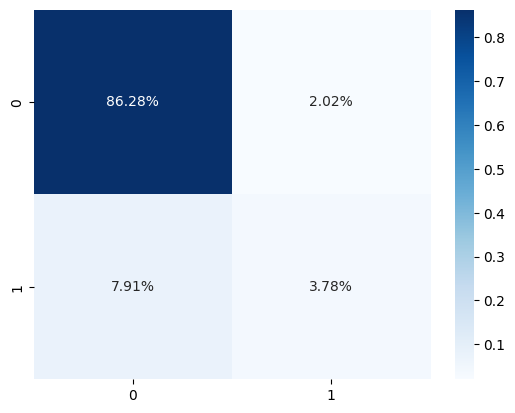

In [36]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [37]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     39922
           1       0.65      0.32      0.43      5289

    accuracy                           0.90     45211
   macro avg       0.78      0.65      0.69     45211
weighted avg       0.89      0.90      0.89     45211



# K Nearest Neighbours

In [38]:
Ks = 10
mean_acc = np.zeros((Ks))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train.values,y_train.values)
    yhat=neigh.predict(x_test.values)
    mean_acc[n] = accuracy_score(y_test, yhat)

mean_acc

array([0.        , 1.        , 0.92855721, 0.93198558, 0.91521975,
       0.91860388, 0.91077393, 0.91331756, 0.9084736 , 0.9102652 ])

We will select k = 3 as this gives us the highest accuracy and again print classification report

In [39]:
k = 3
Knn = KNeighborsClassifier(n_neighbors=k)
Knn.fit(x_train.values, y_train.values)
yhat = Knn.predict(x_test.values)

In [ ]:
cf_matrix = confusion_matrix(y_test, yhat)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='Blues', fmt='.2%')

In [ ]:
print (classification_report(y_test, yhat))

We find that KNearestNeighbors is better at classifying the given dataset basis classification report accuracy

# Support Vector Machine

In [ ]:
SVM_df = svm.SVC()

In [ ]:
# ,'poly','sigmoid'
parameters_grid_SVC = {'kernel':('linear', 'rbf','poly','sigmoid'),
              'C' : [0.1, 1, 10],
              }

In [ ]:
# clf = GridSearchCV(SVM_df, parameters_grid_SVC, n_jobs=-1)
# clf.fit(x_train, y_train)

In [ ]:
# clf.best_params_

In [ ]:
# {'C': 0.1, 'kernel': 'linear'} as per clf.best_params_, GridSearchCV takes approx 40 minutes to fit x_train and y_train data
SVM_df = svm.SVC(kernel='linear', C=0.1)
SVM_df.fit(x_train, y_train)

In [ ]:
yhat = SVM_df.predict(x_test)

*Checking accuracy*

In [ ]:
# Confusion matrix
cf_matrix = confusion_matrix(y_test, yhat)
sns.heatmap(cf_matrix / np.sum(cf_matrix), cmap = 'Blues', annot = True, fmt='.2%')

In [ ]:
print(classification_report(y_test, yhat))

# Naive Bayes

*Gaussian distribution*

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(x_train, y_train)
yhat = clf.predict(x_test)
print(classification_report(y_test, yhat))

*Bernoulli Distribution with binarize set to True*

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(binarize=True).fit(x_train, y_train)
yhat = clf.predict(x_test)
print(classification_report(y_test, yhat))

In [ ]:
cm = confusion_matrix(y_test,yhat)
sns.heatmap(cm/np.sum(cm), fmt = '.2%', cmap='Blues', annot=True)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='entropy', splitter='best')
clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
print(classification_report(y_test, yhat))

In [ ]:
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm/np.sum(cm), annot=True, fmt = '.2%', cmap='Blues')

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, criterion='gini', n_jobs= -1, random_state=42)
clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
cm = confusion_matrix(y_test, yhat)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='0.2%', cmap = 'Blues')

In [ ]:
print(classification_report(y_test, yhat))

# Selecting the best classification algorithm

In [ ]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
plt.figure(figsize = (20,12))
plt.plot([0,1], [0,1], 'r--')

In [ ]:
probs_LR = LR.predict_proba(x_test)
print(probs_LR)

In [ ]:
np.sort(probs_LR[:,1])[::-1]